# 04a Rank CATE estimators GI

In the previous notebook, we saw that estimators do not have good prediction performance, and neither are  
they sufficiently stable in general. On the other hand, the banded ordering of individuals generalizes. In  
this notebook, we measure this generalization performance in terms of the $t$-statistic. We rank the  
various estimators w.r.t. this statistic, and select the ones with which to form an ensemble.

The data perturbations are:  
1. No perturbation  
2. Stratified CV split with different random seed  
3. Another stratified CV split with different random seed  
4. CV split using enrollment time to define folds  
5. Replacing overweight feature with obese (using a different BMI threshold)  
6. Changing age threshold for elderly feature from 65 to 60  
7. Changing the outcome of interest to all GI events instead of just confirmed GI events  

### Contents:
1. Set up  
1.1. Create, save and/or load the scores data frame  
2. Aggregate the $t$-statistics in various ways  
2.1. Aggregate within each data perturbation  
2.2. Aggregate within each q value  
2.3. Aggregate over everything  
3. $t$-statistic variability  
4. Selecting the top estimators  
4.1. Further investigation and plots  
4.2. Outputting names of top estimators

## 1. Set up

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import sys
import copy
import random
import joblib

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import pylab

# Import own methods
from methods.cate_estimator_validation import (get_estimator_scores, aggregate_estimator_scores, 
                                               get_t_r2_statistics)

Failed to import duecredit due to No module named 'duecredit'


If scores are already cached, load them instead of running 1.1.

### 1.1. Create, save and/or load the scores data frame

Compute the t-statistics for the different estimators across different folds and data perturbations. Store the result in the  data frame ``scores_df``.

In [ ]:
# Load the scores data frame
outcome_name = "fausebal"
q_values = np.array([0.5, 0.4, 0.3, 0.2, 0.1])
dir_neg = True
try: 
    scores_df = joblib.load(f"output/analysis/{outcome_name}/{outcome_name}_scores_df.pkl")
except:
    file_path = f"output/analysis/{outcome_name}/{outcome_name}_fitted_libraries.pkl"
    fitted_libraries = joblib.load(file_path)
    scores_df = get_estimator_scores(fitted_libraries, q_values, 
                                    dir_neg = dir_neg, kind = "val")
    joblib.dump(scores_df, f"output/analysis/{outcome_name}/{outcome_name}_scores_df.pkl")
    del fitted_libraries

## 2. Aggregate the $t$-statistics in various ways

### 2.1. Aggregate within each data perturbation

In [6]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name="mean", 
                                        group_by = "perturbation")
results_df["mean"] = results_df.apply(np.mean, axis = 1)

In [7]:
results_df.round(2)

pert=none  pert=cv_0  pert=cv_1  mean
estimator                                             
s_xgb                -0.25       0.45      -0.13  0.02
s_rf                 -0.68      -0.72       0.16 -0.42
t_lasso              -0.08       0.08      -0.08 -0.03
t_logistic            0.39       0.66       0.49  0.51
t_rf                 -0.33      -0.41      -0.62 -0.45
t_xgb                -0.47      -0.30      -0.43 -0.40
x_lasso              -0.37       0.02      -0.28 -0.21
x_logistic           -0.31      -0.20      -0.17 -0.23
x_rf                 -0.54      -0.82      -0.70 -0.69
x_xgb                  NaN        NaN        NaN   NaN
r_lassolasso           NaN        NaN        NaN   NaN
r_lassoxgb            0.19      -0.02       0.61  0.26
r_lassorf             0.19       0.54       0.46  0.40
r_rflasso              NaN        NaN        NaN   NaN
r_rfrf               -0.53      -0.09      -0.79 -0.47
r_rfxgb               0.23      -0.05       0.30  0.16
r_xgblasso             NaN        NaN        NaN   NaN
r_xgbrf               0.14       0.26       0.17  0.19
r_xgbxgb              0.02       0.26       0.19  0.16
causal_tree_1        -0.02      -0.95      -0.29 -0.42
causal_tree_2        -1.10      -0.95       0.01 -0.68
causal_forest_1      -0.46       0.18      -0.42 -0.23
causal_forest_2      -0.94      -0.09      -0.52 -0.52

In [8]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name = "rank_mean", 
                                        group_by = "perturbation")
results_df["mean"] = results_df.apply(np.mean, axis = 1)

In [9]:
results_df.sort_values("mean").round(2)

pert=none  pert=cv_0  pert=cv_1   mean
estimator                                              
causal_tree_2         5.20       6.15      10.85   7.40
x_rf                  8.10       7.40       7.05   7.52
causal_forest_2       5.30       9.90       7.40   7.53
r_rfrf                7.30       9.95       5.40   7.55
t_rf                 10.05       7.65       7.00   8.23
t_xgb                 7.70       8.70       9.20   8.53
s_rf                  7.80       6.55      11.85   8.73
causal_tree_1        11.70       5.80       9.40   8.97
causal_forest_1       8.05      11.60       7.80   9.15
x_logistic           10.05       9.95       9.90   9.97
x_lasso              10.10      11.00       9.15  10.08
s_xgb                 9.20      13.25       9.65  10.70
t_lasso              11.45      10.75      10.10  10.77
r_rfxgb              12.95       9.65      11.70  11.43
r_xgbxgb             12.00      11.50      11.55  11.68
r_xgbrf              12.45      12.00      11.90  12.12
r_lassoxgb           13.35      10.15      14.25  12.58
r_lassorf            12.90      13.60      12.75  13.08
t_logistic           14.35      14.45      13.10  13.97
x_xgb                  NaN        NaN        NaN    NaN
r_lassolasso           NaN        NaN        NaN    NaN
r_rflasso              NaN        NaN        NaN    NaN
r_xgblasso             NaN        NaN        NaN    NaN

### 2.2. Aggregated within each q value

In [10]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name = "mean", 
                                        group_by = "q_value")
results_df["mean"] = results_df.apply(np.mean, axis = 1)

In [11]:
results_df.sort_values("mean").round(2)

0.1   0.2   0.3   0.4   0.5  mean
estimator                                          
x_rf            -0.33 -0.79 -0.73 -0.87 -0.72 -0.69
causal_tree_2   -0.85 -0.66 -0.53 -0.57 -0.79 -0.68
causal_forest_2 -1.24 -0.75 -0.38 -0.16 -0.05 -0.52
r_rfrf          -0.63 -0.43 -0.47 -0.40 -0.44 -0.47
t_rf            -0.90 -0.76 -0.11 -0.37 -0.13 -0.45
causal_tree_1   -0.72 -0.60 -0.45 -0.26 -0.07 -0.42
s_rf            -0.18 -0.16 -0.61 -0.62 -0.52 -0.42
t_xgb           -0.53 -0.32 -0.49 -0.34 -0.31 -0.40
causal_forest_1 -0.91 -0.60 -0.08  0.10  0.34 -0.23
x_logistic       0.05 -0.42 -0.20 -0.27 -0.29 -0.23
x_lasso         -0.15 -0.08 -0.34 -0.46 -0.02 -0.21
t_lasso         -0.17 -0.20 -0.28  0.04  0.47 -0.03
s_xgb           -0.10 -0.06  0.15  0.13 -0.01  0.02
r_xgbxgb        -0.09  0.04  0.20  0.33  0.30  0.16
r_rfxgb         -0.11  0.09  0.28  0.11  0.43  0.16
r_xgbrf          0.01  0.18  0.29  0.35  0.11  0.19
r_lassoxgb       0.34  0.26  0.21  0.13  0.37  0.26
r_lassorf       -0.13  0.44  0.63  0.63  0.42  0.40
t_logistic      -0.06  0.59  0.53  0.72  0.79  0.51
x_xgb             NaN   NaN   NaN   NaN   NaN   NaN
r_lassolasso      NaN   NaN   NaN   NaN   NaN   NaN
r_rflasso         NaN   NaN   NaN   NaN   NaN   NaN
r_xgblasso        NaN   NaN   NaN   NaN   NaN   NaN

Takeaway: Top estimators for various q values can be different. There is also a fair amount of variability between q values for each estimator.

### 2.3. Aggregated over everything

In [12]:
aggregate_estimator_scores(scores_df, aggregation_func_name="mean", 
                           group_by = "none").sort_values("mean").round(2)

mean   std  rank_mean  top_10_freq
estimator                                          
x_rf            -0.69  1.01       7.52         0.70
causal_tree_2   -0.68  0.96       7.40         0.72
causal_forest_2 -0.52  0.87       7.53         0.72
r_rfrf          -0.47  0.75       7.55         0.80
t_rf            -0.45  1.06       8.23         0.68
causal_tree_1   -0.42  1.01       8.97         0.58
s_rf            -0.42  0.92       8.73         0.62
t_xgb           -0.40  0.88       8.53         0.70
causal_forest_1 -0.23  0.82       9.15         0.60
x_logistic      -0.23  0.91       9.97         0.55
x_lasso         -0.21  0.93      10.08         0.47
t_lasso         -0.03  0.94      10.77         0.50
s_xgb            0.02  0.90      10.70         0.47
r_xgbxgb         0.16  0.86      11.68         0.40
r_rfxgb          0.16  1.05      11.43         0.42
r_xgbrf          0.19  0.72      12.12         0.30
r_lassoxgb       0.26  0.85      12.58         0.30
r_lassorf        0.40  0.89      13.08         0.28
t_logistic       0.51  0.88      13.97         0.20
x_xgb             NaN   NaN        NaN         0.00
r_lassolasso      NaN   NaN        NaN         0.00
r_rflasso         NaN   NaN        NaN         0.00
r_xgblasso        NaN   NaN        NaN         0.00

Takeaway: Various methods of ranking the estimators produce pretty consistent results

## 3. $t$-statistic variability

In [13]:
# Plot style settings
plt.style.use("fivethirtyeight")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True

In [14]:
# Get data to make plot
selected_estimators = list(scores_df.index.to_list())
selected_estimators.remove("r_lassoxgb")

selected_estimators = np.array(selected_estimators)
estimator_argsort = np.argsort([scores_df.loc[estimator].mean() for estimator in selected_estimators])
selected_estimators = selected_estimators[estimator_argsort]

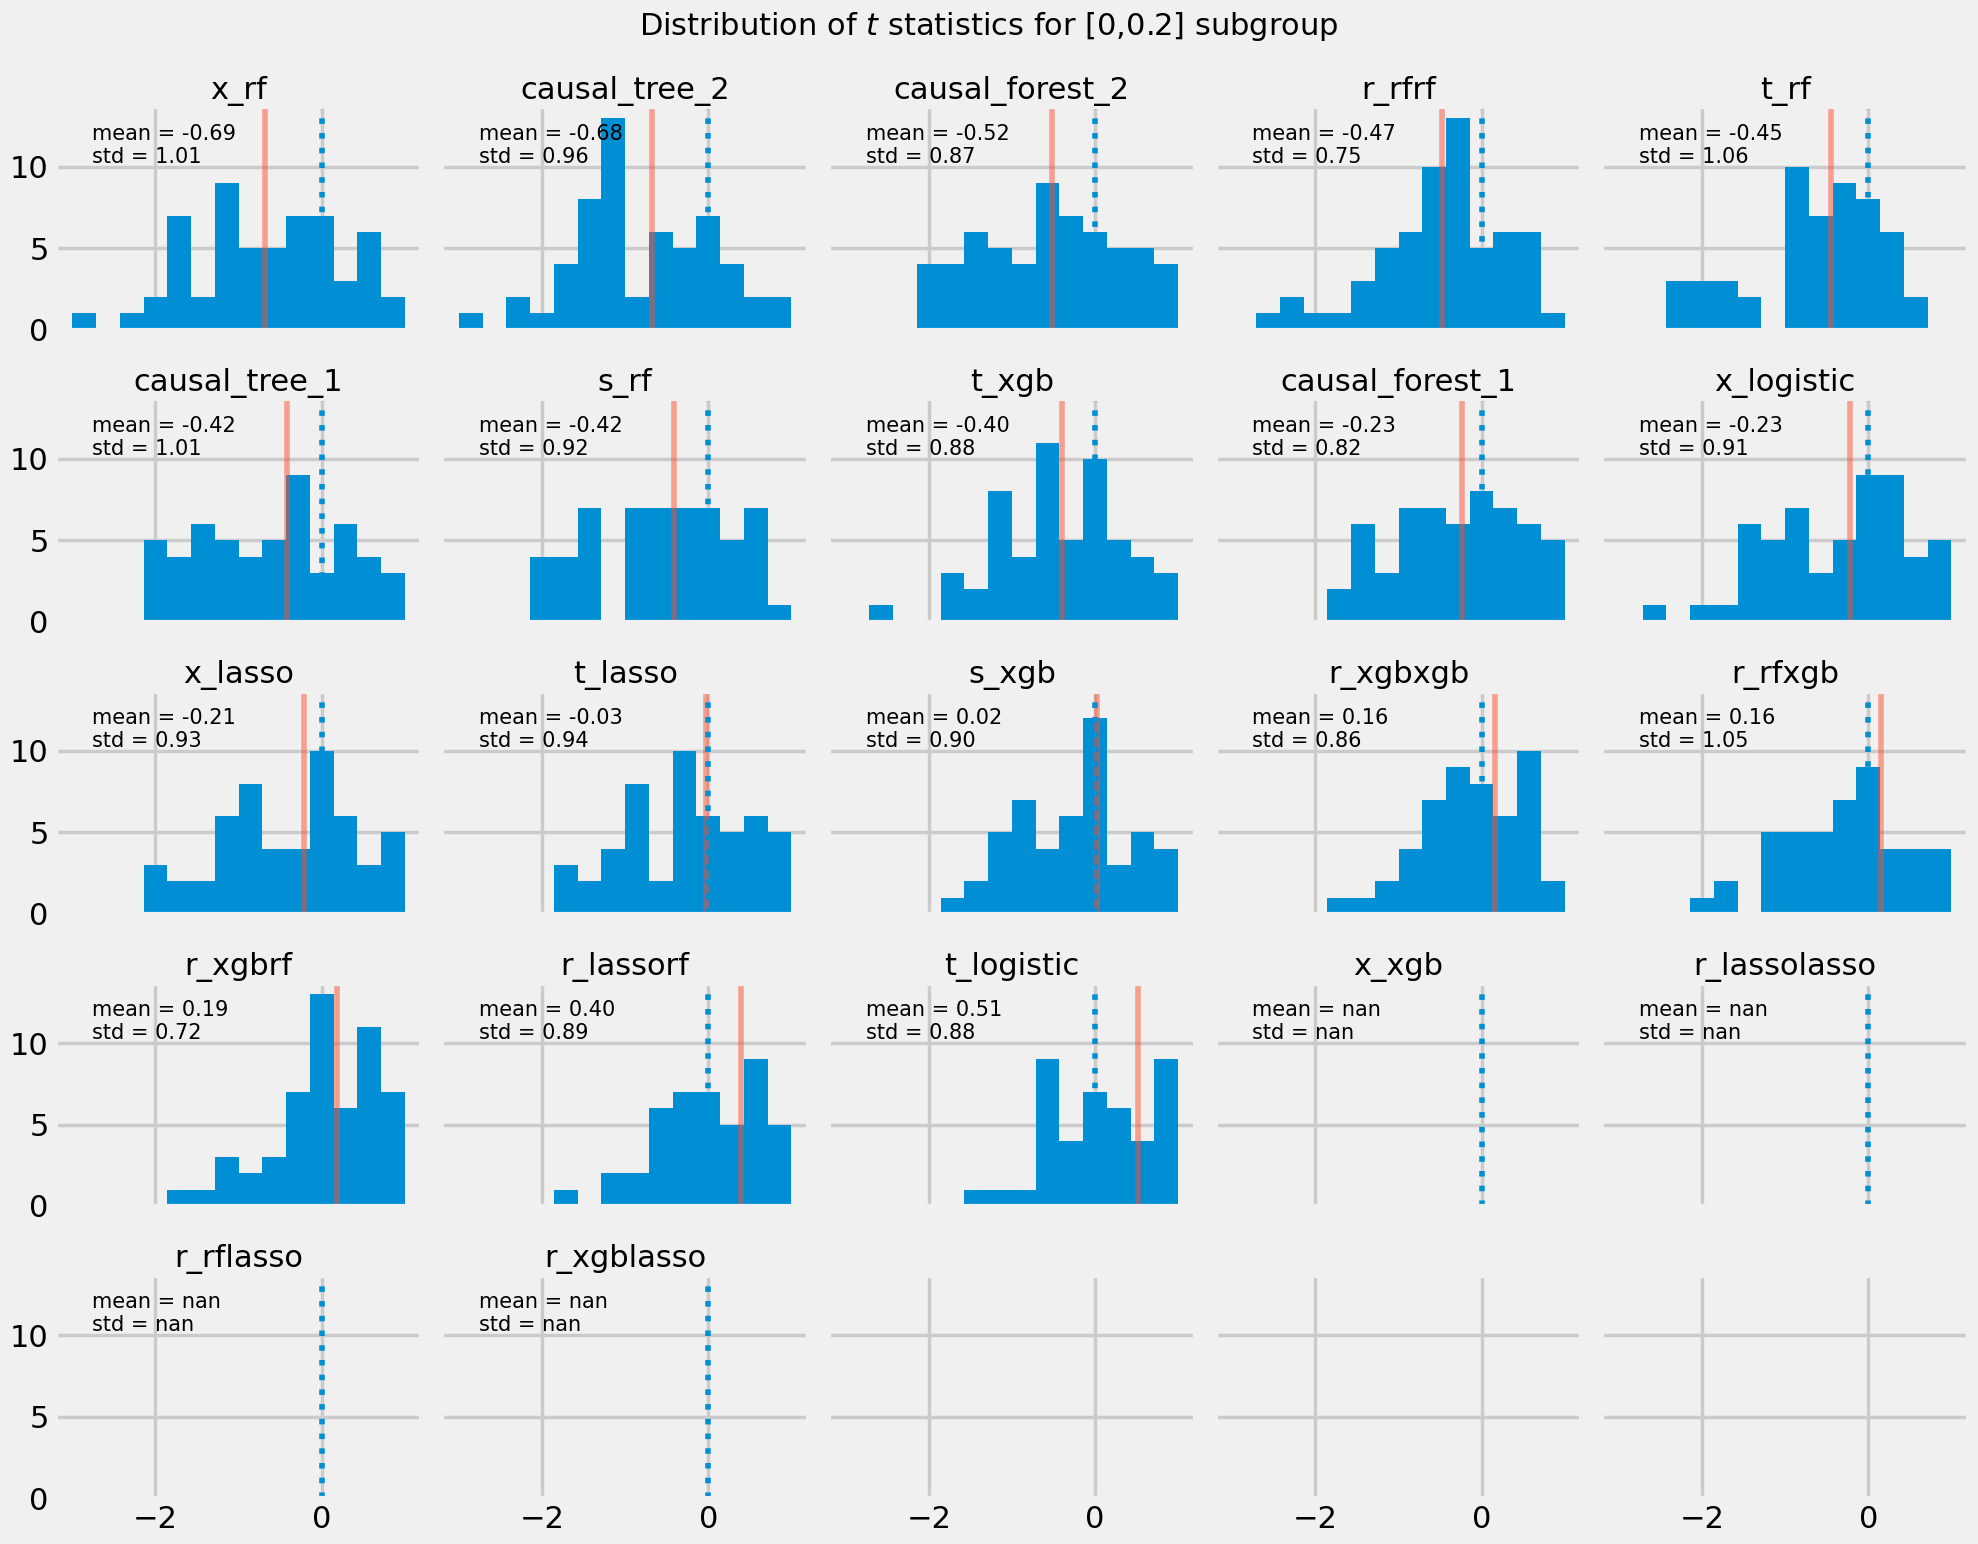

In [16]:
f, axes = plt.subplots(5, 5, figsize=[20, 15], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(selected_estimators):
    ax = axes[i]
    ax.hist(scores_df.loc[estimator], bins = np.linspace(-3,1,15))
    mean_score = scores_df.loc[estimator].mean()
    score_std = scores_df.loc[estimator].std()
    ax.axvline(mean_score, linestyle='-', color=colors[1], alpha=0.5)
    ax.axvline(0, alpha=1., linestyle=':')
    ax.annotate(f"mean = {mean_score:.2f}\nstd = {score_std:.2f}",
                xy = (.1, .75), xycoords = ax.transAxes,
                fontsize = 15)
    ax.set_title(estimator)
#    ax.set_xticks([-2, -1, 0, 1.])
#    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle(r"Distribution of $t$ statistics for [0,0.2] subgroup", y = 1.03)
plt.show()

$t$-statistic standard deviation for various estimators roughly comparable.

In [17]:
modified_scores_df = scores_df.drop(index = "r_lassoxgb")
get_t_r2_statistics(modified_scores_df)

R2
q values      NaN
perturbations NaN
estimators    NaN

Takeaway: No one stratification factor accounts for a significant amount of the variance in $t$-statistics.

## 4. Selecting the top estimators

### 4.1. Further investigation and plots

We first return to aggregating $t$-statistics within each perturbation type.

In [19]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name="mean", 
                                        group_by = "perturbation")
results_df = results_df.drop(index="r_lassoxgb")
results_df = results_df[[ 'pert=none', 'pert=cv_0', 'pert=cv_1']]
ranking_df = results_df.rank()
ranking_df["max"] = ranking_df.apply(np.max, axis = 1)
ranking_df = ranking_df.sort_values("max")

results_df = results_df.reindex(index=ranking_df.index).round(2)

In [20]:
results_df

pert=none  pert=cv_0  pert=cv_1
estimator                                       
x_rf                 -0.54      -0.82      -0.70
t_xgb                -0.47      -0.30      -0.43
r_rfrf               -0.53      -0.09      -0.79
t_rf                 -0.33      -0.41      -0.62
causal_forest_2      -0.94      -0.09      -0.52
x_logistic           -0.31      -0.20      -0.17
x_lasso              -0.37       0.02      -0.28
t_lasso              -0.08       0.08      -0.08
causal_tree_2        -1.10      -0.95       0.01
s_rf                 -0.68      -0.72       0.16
causal_forest_1      -0.46       0.18      -0.42
causal_tree_1        -0.02      -0.95      -0.29
r_xgbxgb              0.02       0.26       0.19
r_xgbrf               0.14       0.26       0.17
s_xgb                -0.25       0.45      -0.13
r_rfxgb               0.23      -0.05       0.30
r_lassorf             0.19       0.54       0.46
t_logistic            0.39       0.66       0.49
x_xgb                  NaN        NaN        NaN
r_lassolasso           NaN        NaN        NaN
r_rflasso              NaN        NaN        NaN
r_xgblasso             NaN        NaN        NaN

In [21]:
ranking_df

pert=none  pert=cv_0  pert=cv_1   max
estimator                                             
x_rf                   4.0        3.0        2.0   4.0
t_xgb                  6.0        6.0        5.0   6.0
r_rfrf                 5.0        8.0        1.0   8.0
t_rf                   9.0        5.0        3.0   9.0
causal_forest_2        2.0        9.0        4.0   9.0
x_logistic            10.0        7.0        9.0  10.0
x_lasso                8.0       11.0        8.0  11.0
t_lasso               12.0       12.0       11.0  12.0
causal_tree_2          1.0        1.0       12.0  12.0
s_rf                   3.0        4.0       13.0  13.0
causal_forest_1        7.0       13.0        6.0  13.0
causal_tree_1         13.0        2.0        7.0  13.0
r_xgbxgb              14.0       14.0       15.0  15.0
r_xgbrf               15.0       15.0       14.0  15.0
s_xgb                 11.0       16.0       10.0  16.0
r_rfxgb               17.0       10.0       16.0  17.0
r_lassorf             16.0       17.0       17.0  17.0
t_logistic            18.0       18.0       18.0  18.0
x_xgb                  NaN        NaN        NaN   NaN
r_lassolasso           NaN        NaN        NaN   NaN
r_rflasso              NaN        NaN        NaN   NaN
r_xgblasso             NaN        NaN        NaN   NaN

In [2]:
# Run this to get latex code for table
#print(results_df.round(2).to_latex())

In [22]:
joblib.dump([results_df, ranking_df], f"output/analysis/{outcome_name}/{outcome_name}_t_boxplot_data.pkl")

['output/analysis/fausebal/fausebal_t_boxplot_data.pkl']

In [23]:
# Plot style settings
plt.style.use("fivethirtyeight")
label_size = 23
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True


plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'
SAVE_PATH  = f"figs/{outcome_name}/"


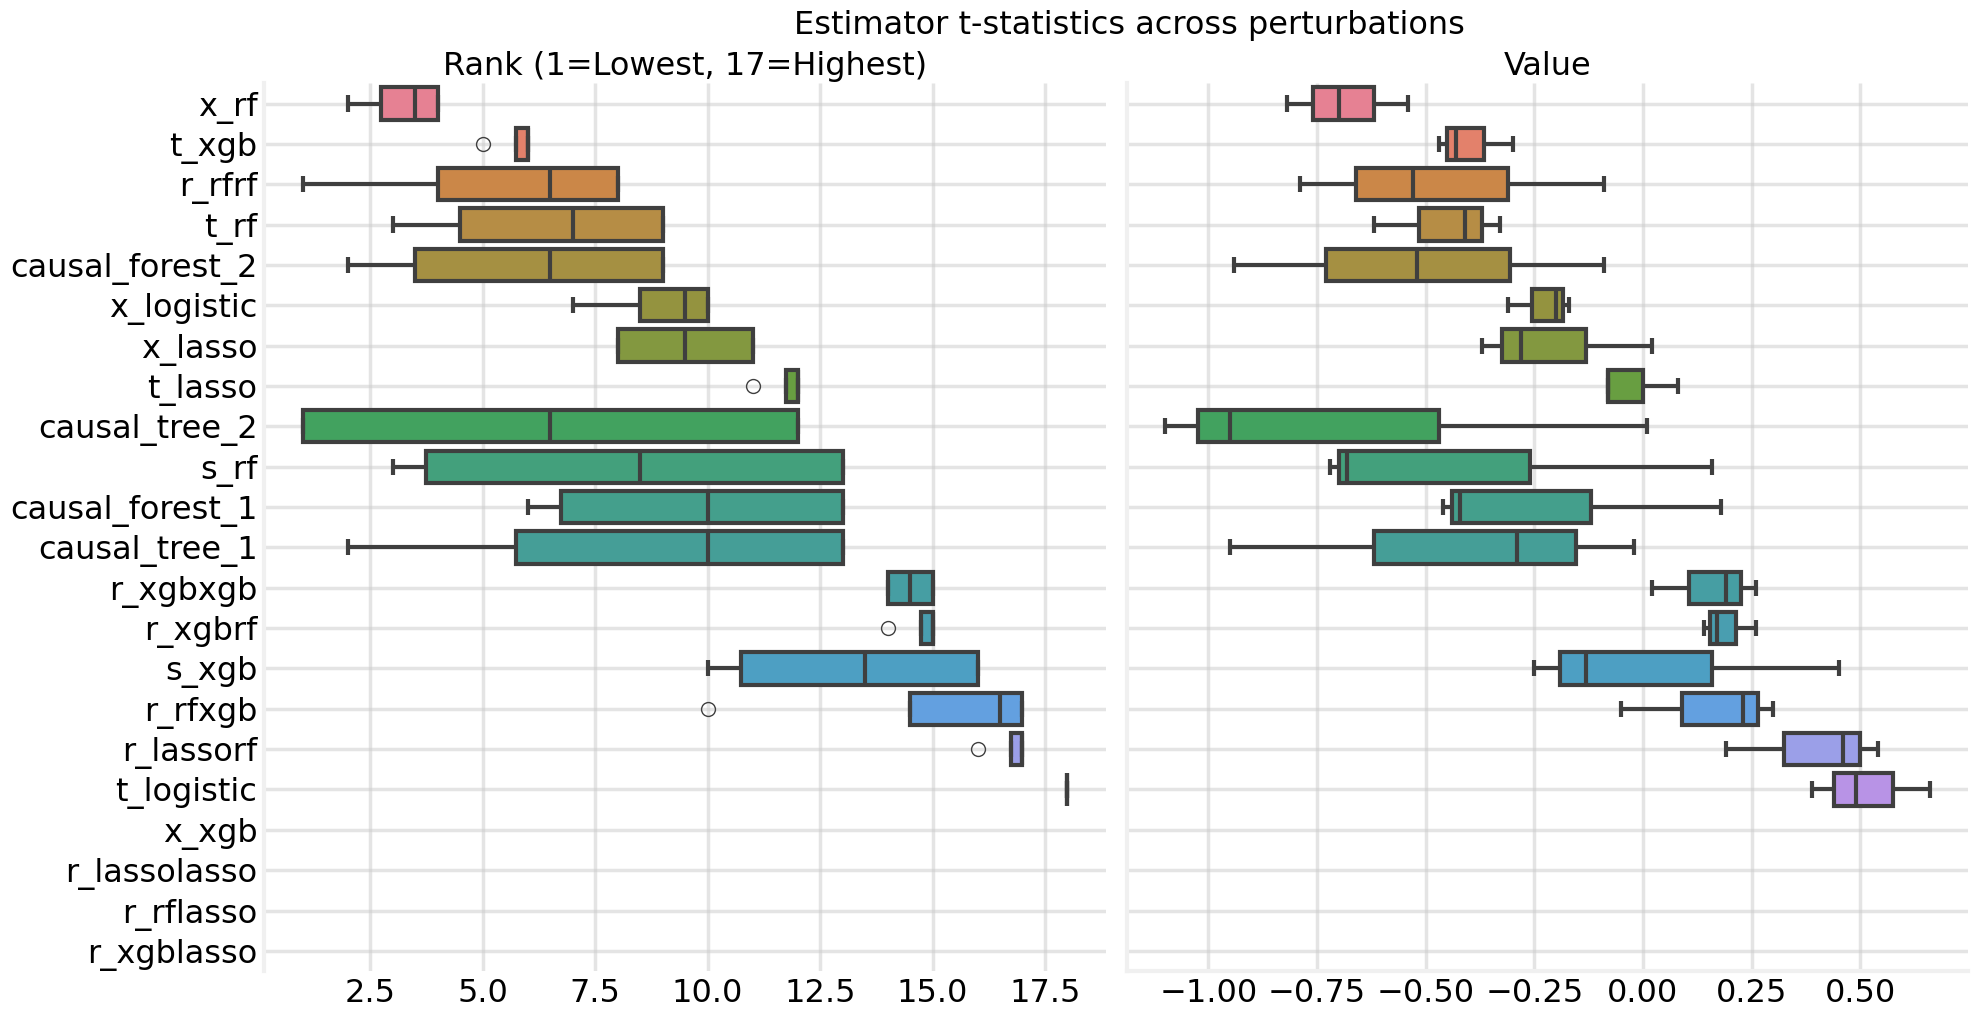

In [24]:
savfig = False
fig, axes = plt.subplots(1, 2, sharey=True, figsize=[20, 10])

ax = axes[0]
box_plot = sns.boxplot(data=ranking_df.T, orient='h',fliersize=10, linewidth=3, ax=ax)
ax.set_ylabel('')
ax.set_title("Rank (1=Lowest, 17=Highest)", x=0.5, y=1)
ax.grid(True, alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.set_xlabel("Value")

ax = axes[1]
box_plot = sns.boxplot(data=results_df.reindex(index=ranking_df.index).T, orient='h',fliersize=10, linewidth=3, ax=ax)
ax.set_ylabel('')
ax.set_title("Value", y=1)
ax.grid(True,  alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.set_xlabel("Value")
plt.tight_layout()
plt.suptitle("Estimator t-statistics across perturbations", x=0.57, y=1.02)
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_scores_rank_estimators.pdf",bbox_inches='tight')
plt.show()
# sns.boxplot(data=monotonicity_df, ax=ax, fliersize=10, linewidth=3)


### 4.2. Outputting names of top estimators

Let's isolate the estimators whose ranks (within each perturbation type) are always at most 10.

In [25]:
ranking_df["max"] = ranking_df.filter(regex = "pert").max(axis = 1)
ranking_df[ranking_df["max"] <= 11]

pert=none  pert=cv_0  pert=cv_1   max
estimator                                             
x_rf                   4.0        3.0        2.0   4.0
t_xgb                  6.0        6.0        5.0   6.0
r_rfrf                 5.0        8.0        1.0   8.0
t_rf                   9.0        5.0        3.0   9.0
causal_forest_2        2.0        9.0        4.0   9.0
x_logistic            10.0        7.0        9.0  10.0
x_lasso                8.0       11.0        8.0  11.0

Selected estimators: ``x_lasso, x_rf, t_rf, t_lasso, x_xgb, x_logistic``

In [26]:
outcome_name = "fausebal"
top_estimator_names = list(ranking_df[ranking_df["max"] <= 11].index)
joblib.dump(top_estimator_names, f"output/analysis/{outcome_name}/{outcome_name}_top_estimator_names.pkl")

['output/analysis/fausebal/fausebal_top_estimator_names.pkl']